In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/cifar10/sisa

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 465 (delta 14), reused 34 (delta 9), pack-reused 374 (from 3)
Receiving objects: 100% (465/465), 628.99 MiB | 38.74 MiB/s, done.
Resolving deltas: 100% (149/149), done.
Updating files: 100% (69/69), done.
/kaggle/working/machine_unlearning_experiments/experiments/cifar10/sisa


## Dependencies

In [2]:
import sys
import json
from pathlib import Path
from torchvision import datasets

## Utils

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [4]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

# Init model
from models.resnet50 import init_model_resnet50

# Create sisa structure
from methods.sisa.sisa_utils import create_sisa_structure

# Recreate sisa dataloaders from json file
from methods.sisa.sisa_utils import recreate_sisa_dataloaders

# SISA train & test loop
import methods.sisa.sisa_train_test as stt
from methods.sisa.sisa_train_test import sisa_train, sisa_test, retrain_sisa_framework

# Aggregate SISA models, via weighted voting
from methods.sisa.sisa_utils import evaluate_aggregated_model, update_sisa_structure

Device used: cuda


## Parameters (arbitrary chosen)

In [30]:
BATCH_SIZE = 256

LEARNING_RATE = 5e-5

EPOCHS = 5

SHARDS = 3

SLICES = 5

stt.MULTI_GPU = True

# SISA structure

## Get data transform

In [27]:
*_, transform = init_model_resnet50()
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Init model...
Done initializing model.
Model ID: 132854008332144, Optimizer ID: 132854008331904, Criterion ID: 132854008331952


## Load dataset

In [28]:
train_dataset = datasets.CIFAR10(root=data_root, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=data_root, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


## Create SISA structure

In [29]:
create_sisa_structure(train_dataset, shards=SHARDS, slices_per_shard=SLICES)

SISA structure saved to sisa_structure.json


In [15]:
sisa_structure_file = 'sisa_structure.json'

## Prepare DataLoaders from json file

In [10]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=sisa_structure_file,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

# Train using SISA framework

## Models output path

In [11]:
save_models_metrics_dir = './sisa_models'

## Call train

In [12]:
import time

start_time = time.perf_counter()
sisa_train(
    dataloaders=dataloaders, 
    num_epochs=EPOCHS, 
    save_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_resnet50,
    learning_rate=LEARNING_RATE,
    )

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Training shard: shard_0
Init model...
Done initializing model.
Model ID: 133947227881776, Optimizer ID: 133947221933840, Criterion ID: 133947221933984
  Training slice: slice_0


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Epoch [1/5], Train Loss: 2.1566, Train Accuracy: 0.3350, Val Loss: 2.0697, Val Accuracy: 0.5105
Epoch 1: New best validation accuracy: 0.5105. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Epoch [2/5], Train Loss: 1.6209, Train Accuracy: 0.6977, Val Loss: 1.2202, Val Accuracy: 0.7357
Epoch 2: New best validation accuracy: 0.7357. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epoch [3/5], Train Loss: 0.9473, Train Accuracy: 0.8127, Val Loss: 0.6389, Val Accuracy: 0.8138
Epoch 3: New best validation accuracy: 0.8138. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Epoch [4/5], Train Loss: 0.4572, Train Accuracy: 0.9023, Val Loss: 0.4402, Val Accuracy: 0.8529
Epoch 4: New best validation accuracy: 0.8529. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epoch [5/5], Train Loss: 0.2117, Train Accuracy: 0.9583, Val Loss: 0.3875, Val Accuracy: 0.8829
Epoch 5: New best validation accuracy: 0.8829. Model saved to ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_0_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_0_ResNet50_CIFAR10_history.json'.
  Training slice: slice_1


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epoch [1/5], Train Loss: 0.4663, Train Accuracy: 0.8553, Val Loss: 0.3567, Val Accuracy: 0.8949
Epoch 1: New best validation accuracy: 0.8949. Model saved to ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epoch [2/5], Train Loss: 0.1829, Train Accuracy: 0.9603, Val Loss: 0.2990, Val Accuracy: 0.8979
Epoch 2: New best validation accuracy: 0.8979. Model saved to ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Epoch [3/5], Train Loss: 0.0879, Train Accuracy: 0.9830, Val Loss: 0.2876, Val Accuracy: 0.9129
Epoch 3: New best validation accuracy: 0.9129. Model saved to ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch [4/5], Train Loss: 0.0468, Train Accuracy: 0.9947, Val Loss: 0.2840, Val Accuracy: 0.9129


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch [5/5], Train Loss: 0.0286, Train Accuracy: 0.9977, Val Loss: 0.3059, Val Accuracy: 0.9159
Epoch 5: New best validation accuracy: 0.9159. Model saved to ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_0_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_1_ResNet50_CIFAR10_history.json'.
  Training slice: slice_2


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epoch [1/5], Train Loss: 0.3528, Train Accuracy: 0.8907, Val Loss: 0.3431, Val Accuracy: 0.8559
Epoch 1: New best validation accuracy: 0.8559. Model saved to ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch [2/5], Train Loss: 0.1171, Train Accuracy: 0.9700, Val Loss: 0.2602, Val Accuracy: 0.9009
Epoch 2: New best validation accuracy: 0.9009. Model saved to ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Epoch [3/5], Train Loss: 0.0477, Train Accuracy: 0.9923, Val Loss: 0.2579, Val Accuracy: 0.9039
Epoch 3: New best validation accuracy: 0.9039. Model saved to ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch [4/5], Train Loss: 0.0250, Train Accuracy: 0.9973, Val Loss: 0.2901, Val Accuracy: 0.8919


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch [5/5], Train Loss: 0.0209, Train Accuracy: 0.9970, Val Loss: 0.2766, Val Accuracy: 0.9099
Epoch 5: New best validation accuracy: 0.9099. Model saved to ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_0_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_2_ResNet50_CIFAR10_history.json'.
  Training slice: slice_3


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Epoch [1/5], Train Loss: 0.3350, Train Accuracy: 0.8997, Val Loss: 0.3187, Val Accuracy: 0.9069
Epoch 1: New best validation accuracy: 0.9069. Model saved to ./sisa_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epoch [2/5], Train Loss: 0.1205, Train Accuracy: 0.9693, Val Loss: 0.2563, Val Accuracy: 0.9159
Epoch 2: New best validation accuracy: 0.9159. Model saved to ./sisa_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Epoch [3/5], Train Loss: 0.0467, Train Accuracy: 0.9897, Val Loss: 0.2378, Val Accuracy: 0.9159


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epoch [4/5], Train Loss: 0.0311, Train Accuracy: 0.9943, Val Loss: 0.2179, Val Accuracy: 0.9309
Epoch 4: New best validation accuracy: 0.9309. Model saved to ./sisa_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch [5/5], Train Loss: 0.0182, Train Accuracy: 0.9977, Val Loss: 0.2152, Val Accuracy: 0.9279
Training complete for ./sisa_models/shard_0_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_3_ResNet50_CIFAR10_history.json'.
  Training slice: slice_4


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Epoch [1/5], Train Loss: 0.2999, Train Accuracy: 0.9080, Val Loss: 0.2608, Val Accuracy: 0.9069
Epoch 1: New best validation accuracy: 0.9069. Model saved to ./sisa_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Epoch [2/5], Train Loss: 0.0924, Train Accuracy: 0.9740, Val Loss: 0.2514, Val Accuracy: 0.9249
Epoch 2: New best validation accuracy: 0.9249. Model saved to ./sisa_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Epoch [3/5], Train Loss: 0.0376, Train Accuracy: 0.9917, Val Loss: 0.2729, Val Accuracy: 0.9219


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Epoch [4/5], Train Loss: 0.0197, Train Accuracy: 0.9987, Val Loss: 0.2627, Val Accuracy: 0.9279
Epoch 4: New best validation accuracy: 0.9279. Model saved to ./sisa_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch [5/5], Train Loss: 0.0147, Train Accuracy: 0.9987, Val Loss: 0.2754, Val Accuracy: 0.9219
Training complete for ./sisa_models/shard_0_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_0_slice_4_ResNet50_CIFAR10_history.json'.
Saved final shard model to ./sisa_models/shard_0_final_model.pth
Training shard: shard_1
Init model...
Done initializing model.
Model ID: 133947227797248, Optimizer ID: 133947138914240, Criterion ID: 133947138903872
  Training slice: slice_0


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch [1/5], Train Loss: 2.1929, Train Accuracy: 0.2827, Val Loss: 2.1209, Val Accuracy: 0.4264
Epoch 1: New best validation accuracy: 0.4264. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [2/5], Train Loss: 1.7108, Train Accuracy: 0.6850, Val Loss: 1.4040, Val Accuracy: 0.6156
Epoch 2: New best validation accuracy: 0.6156. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epoch [3/5], Train Loss: 1.0321, Train Accuracy: 0.7973, Val Loss: 0.6895, Val Accuracy: 0.8018
Epoch 3: New best validation accuracy: 0.8018. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.5169, Train Accuracy: 0.8840, Val Loss: 0.5011, Val Accuracy: 0.8168
Epoch 4: New best validation accuracy: 0.8168. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [5/5], Train Loss: 0.2409, Train Accuracy: 0.9483, Val Loss: 0.4400, Val Accuracy: 0.8408
Epoch 5: New best validation accuracy: 0.8408. Model saved to ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_1_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_0_ResNet50_CIFAR10_history.json'.
  Training slice: slice_1


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch [1/5], Train Loss: 0.4804, Train Accuracy: 0.8440, Val Loss: 0.4424, Val Accuracy: 0.8589
Epoch 1: New best validation accuracy: 0.8589. Model saved to ./sisa_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epoch [2/5], Train Loss: 0.1890, Train Accuracy: 0.9527, Val Loss: 0.4155, Val Accuracy: 0.8529


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epoch [3/5], Train Loss: 0.0820, Train Accuracy: 0.9853, Val Loss: 0.3858, Val Accuracy: 0.8679
Epoch 3: New best validation accuracy: 0.8679. Model saved to ./sisa_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.0464, Train Accuracy: 0.9930, Val Loss: 0.3712, Val Accuracy: 0.8889
Epoch 4: New best validation accuracy: 0.8889. Model saved to ./sisa_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [5/5], Train Loss: 0.0252, Train Accuracy: 0.9983, Val Loss: 0.3925, Val Accuracy: 0.8709
Training complete for ./sisa_models/shard_1_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_1_ResNet50_CIFAR10_history.json'.
  Training slice: slice_2


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [1/5], Train Loss: 0.3732, Train Accuracy: 0.8840, Val Loss: 0.3623, Val Accuracy: 0.8799
Epoch 1: New best validation accuracy: 0.8799. Model saved to ./sisa_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [2/5], Train Loss: 0.1215, Train Accuracy: 0.9687, Val Loss: 0.2870, Val Accuracy: 0.8979
Epoch 2: New best validation accuracy: 0.8979. Model saved to ./sisa_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch [3/5], Train Loss: 0.0486, Train Accuracy: 0.9920, Val Loss: 0.2772, Val Accuracy: 0.9039
Epoch 3: New best validation accuracy: 0.9039. Model saved to ./sisa_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epoch [4/5], Train Loss: 0.0305, Train Accuracy: 0.9973, Val Loss: 0.2950, Val Accuracy: 0.8949


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch [5/5], Train Loss: 0.0223, Train Accuracy: 0.9980, Val Loss: 0.2728, Val Accuracy: 0.8979
Training complete for ./sisa_models/shard_1_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_2_ResNet50_CIFAR10_history.json'.
  Training slice: slice_3


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epoch [1/5], Train Loss: 0.3112, Train Accuracy: 0.8970, Val Loss: 0.2762, Val Accuracy: 0.9099
Epoch 1: New best validation accuracy: 0.9099. Model saved to ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch [2/5], Train Loss: 0.0864, Train Accuracy: 0.9780, Val Loss: 0.2731, Val Accuracy: 0.9189
Epoch 2: New best validation accuracy: 0.9189. Model saved to ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [3/5], Train Loss: 0.0395, Train Accuracy: 0.9927, Val Loss: 0.2599, Val Accuracy: 0.9159


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.0230, Train Accuracy: 0.9970, Val Loss: 0.2648, Val Accuracy: 0.9279
Epoch 4: New best validation accuracy: 0.9279. Model saved to ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch [5/5], Train Loss: 0.0172, Train Accuracy: 0.9967, Val Loss: 0.2711, Val Accuracy: 0.9309
Epoch 5: New best validation accuracy: 0.9309. Model saved to ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_models/shard_1_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_3_ResNet50_CIFAR10_history.json'.
  Training slice: slice_4


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [1/5], Train Loss: 0.2928, Train Accuracy: 0.9030, Val Loss: 0.2747, Val Accuracy: 0.9099
Epoch 1: New best validation accuracy: 0.9099. Model saved to ./sisa_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [2/5], Train Loss: 0.0881, Train Accuracy: 0.9747, Val Loss: 0.2243, Val Accuracy: 0.9399
Epoch 2: New best validation accuracy: 0.9399. Model saved to ./sisa_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [3/5], Train Loss: 0.0358, Train Accuracy: 0.9920, Val Loss: 0.2374, Val Accuracy: 0.9309


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.0176, Train Accuracy: 0.9987, Val Loss: 0.2642, Val Accuracy: 0.9339


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [5/5], Train Loss: 0.0117, Train Accuracy: 0.9987, Val Loss: 0.2473, Val Accuracy: 0.9339
Training complete for ./sisa_models/shard_1_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_1_slice_4_ResNet50_CIFAR10_history.json'.
Saved final shard model to ./sisa_models/shard_1_final_model.pth
Training shard: shard_2
Init model...
Done initializing model.
Model ID: 133947933175920, Optimizer ID: 133947138913904, Criterion ID: 133947138903152
  Training slice: slice_0


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


Epoch [1/5], Train Loss: 2.1725, Train Accuracy: 0.2987, Val Loss: 2.0793, Val Accuracy: 0.4835
Epoch 1: New best validation accuracy: 0.4835. Model saved to ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [2/5], Train Loss: 1.6289, Train Accuracy: 0.7137, Val Loss: 1.2927, Val Accuracy: 0.6727
Epoch 2: New best validation accuracy: 0.6727. Model saved to ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [3/5], Train Loss: 0.9845, Train Accuracy: 0.8170, Val Loss: 0.7756, Val Accuracy: 0.7958
Epoch 3: New best validation accuracy: 0.7958. Model saved to ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Epoch [4/5], Train Loss: 0.5023, Train Accuracy: 0.8957, Val Loss: 0.4997, Val Accuracy: 0.8529
Epoch 4: New best validation accuracy: 0.8529. Model saved to ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epoch [5/5], Train Loss: 0.2211, Train Accuracy: 0.9593, Val Loss: 0.4594, Val Accuracy: 0.8438
Training complete for ./sisa_models/shard_2_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_0_ResNet50_CIFAR10_history.json'.
  Training slice: slice_1


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch [1/5], Train Loss: 0.4810, Train Accuracy: 0.8360, Val Loss: 0.3412, Val Accuracy: 0.9039
Epoch 1: New best validation accuracy: 0.9039. Model saved to ./sisa_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epoch [2/5], Train Loss: 0.1945, Train Accuracy: 0.9530, Val Loss: 0.2852, Val Accuracy: 0.8979


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Epoch [3/5], Train Loss: 0.0840, Train Accuracy: 0.9873, Val Loss: 0.2593, Val Accuracy: 0.9339
Epoch 3: New best validation accuracy: 0.9339. Model saved to ./sisa_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [4/5], Train Loss: 0.0458, Train Accuracy: 0.9950, Val Loss: 0.2594, Val Accuracy: 0.9189


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [5/5], Train Loss: 0.0243, Train Accuracy: 0.9983, Val Loss: 0.2540, Val Accuracy: 0.9159
Training complete for ./sisa_models/shard_2_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_1_ResNet50_CIFAR10_history.json'.
  Training slice: slice_2


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [1/5], Train Loss: 0.3373, Train Accuracy: 0.8910, Val Loss: 0.3384, Val Accuracy: 0.8769
Epoch 1: New best validation accuracy: 0.8769. Model saved to ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch [2/5], Train Loss: 0.1240, Train Accuracy: 0.9667, Val Loss: 0.2856, Val Accuracy: 0.8949
Epoch 2: New best validation accuracy: 0.8949. Model saved to ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [3/5], Train Loss: 0.0542, Train Accuracy: 0.9870, Val Loss: 0.2715, Val Accuracy: 0.9129
Epoch 3: New best validation accuracy: 0.9129. Model saved to ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epoch [4/5], Train Loss: 0.0293, Train Accuracy: 0.9967, Val Loss: 0.2556, Val Accuracy: 0.9249
Epoch 4: New best validation accuracy: 0.9249. Model saved to ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epoch [5/5], Train Loss: 0.0183, Train Accuracy: 0.9990, Val Loss: 0.2725, Val Accuracy: 0.9189
Training complete for ./sisa_models/shard_2_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_2_ResNet50_CIFAR10_history.json'.
  Training slice: slice_3


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [1/5], Train Loss: 0.3270, Train Accuracy: 0.8967, Val Loss: 0.2157, Val Accuracy: 0.9249
Epoch 1: New best validation accuracy: 0.9249. Model saved to ./sisa_models/shard_2_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epoch [2/5], Train Loss: 0.1060, Train Accuracy: 0.9730, Val Loss: 0.2551, Val Accuracy: 0.9129


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Epoch [3/5], Train Loss: 0.0409, Train Accuracy: 0.9933, Val Loss: 0.2078, Val Accuracy: 0.9249


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epoch [4/5], Train Loss: 0.0193, Train Accuracy: 0.9973, Val Loss: 0.2081, Val Accuracy: 0.9189


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epoch [5/5], Train Loss: 0.0165, Train Accuracy: 0.9980, Val Loss: 0.2276, Val Accuracy: 0.9249
Training complete for ./sisa_models/shard_2_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_3_ResNet50_CIFAR10_history.json'.
  Training slice: slice_4


Training Epoch 1/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epoch [1/5], Train Loss: 0.2702, Train Accuracy: 0.9158, Val Loss: 0.2638, Val Accuracy: 0.9159
Epoch 1: New best validation accuracy: 0.9159. Model saved to ./sisa_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [2/5], Train Loss: 0.0889, Train Accuracy: 0.9750, Val Loss: 0.1965, Val Accuracy: 0.9219
Epoch 2: New best validation accuracy: 0.9219. Model saved to ./sisa_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Epoch [3/5], Train Loss: 0.0396, Train Accuracy: 0.9903, Val Loss: 0.1818, Val Accuracy: 0.9339
Epoch 3: New best validation accuracy: 0.9339. Model saved to ./sisa_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epoch [4/5], Train Loss: 0.0190, Train Accuracy: 0.9970, Val Loss: 0.2014, Val Accuracy: 0.9159


Training Epoch 5/5:   0%|          | 0/24 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

Epoch [5/5], Train Loss: 0.0167, Train Accuracy: 0.9983, Val Loss: 0.2092, Val Accuracy: 0.9219
Training complete for ./sisa_models/shard_2_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_models/shard_2_slice_4_ResNet50_CIFAR10_history.json'.
Saved final shard model to ./sisa_models/shard_2_final_model.pth
Execution time: 1745.756274 seconds


## Call test

In [23]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_resnet50,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 133947129775584, Optimizer ID: 133947148377760, Criterion ID: 133947148378096
Loading and testing model: ./sisa_models/shard_0_ResNet50_CIFAR10


Evaluating model: ./sisa_models/shard_0_final_model.pth: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Predictions and labels saved to ./sisa_models/shard_0_ResNet50_CIFAR10_predictions.json
Init model...
Done initializing model.
Model ID: 133947129788448, Optimizer ID: 133947152796256, Criterion ID: 133947152796880
Loading and testing model: ./sisa_models/shard_1_ResNet50_CIFAR10


Evaluating model: ./sisa_models/shard_1_final_model.pth: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Predictions and labels saved to ./sisa_models/shard_1_ResNet50_CIFAR10_predictions.json
Init model...
Done initializing model.
Model ID: 133947129788112, Optimizer ID: 133947215358096, Criterion ID: 133947215363376
Loading and testing model: ./sisa_models/shard_2_ResNet50_CIFAR10


Evaluating model: ./sisa_models/shard_2_final_model.pth: 100%|██████████| 79/79 [00:31<00:00,  2.48it/s]

Predictions and labels saved to ./sisa_models/shard_2_ResNet50_CIFAR10_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [24]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9336
  Precision: 0.9339
  Recall: 0.9336
  F1 Score: 0.9336
Shard shard_1 Metrics:
  Accuracy: 0.9359
  Precision: 0.9358
  Recall: 0.9359
  F1 Score: 0.9357
Shard shard_2 Metrics:
  Accuracy: 0.9330
  Precision: 0.9331
  Recall: 0.9330
  F1 Score: 0.9328

Aggregated Model Metrics:
  Accuracy: 0.9463
  Precision: 0.9463
  Recall: 0.9463
  F1 Score: 0.9462


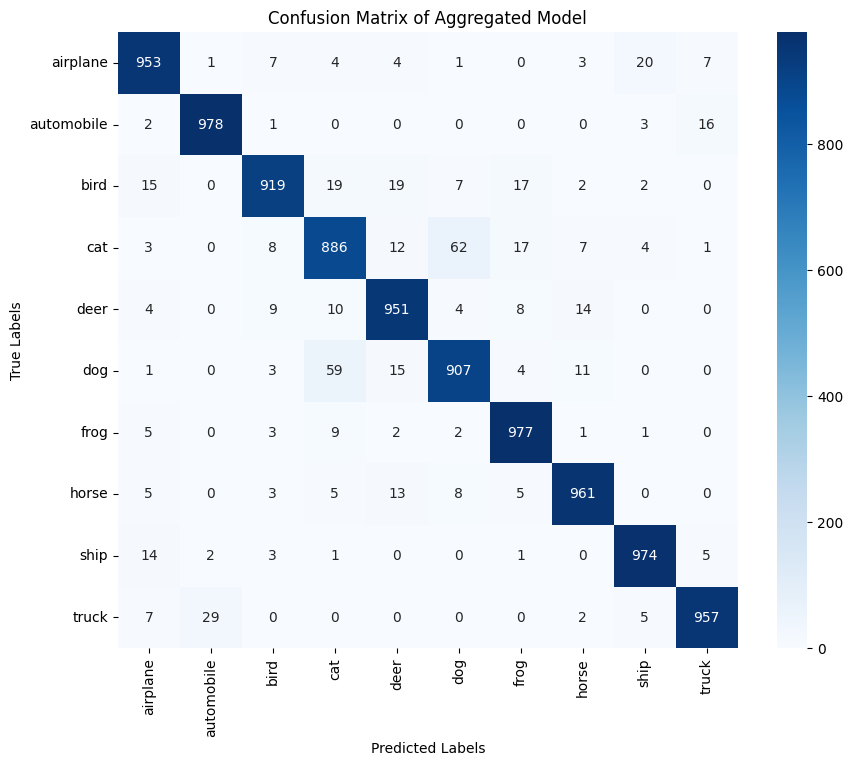

In [26]:
evaluate_aggregated_model(results, classes)

# SISA re-train

## Paths to data info

In [24]:
samples_to_delete = project_root/'experiments/cifar10/naive/cifar10_samples_to_unlearn_30per.json'
sisa_structure = 'sisa_structure.json'
updated_sisa_structure = 'updated_sisa_strucute.json'
deleted_samples = 'deleted_samples.json'

## Update sisa structure -> delete samples 

In [25]:
affected_shards = update_sisa_structure(samples_to_delete, sisa_structure, updated_sisa_structure, deleted_samples)

Retraining Plan:
  Shard: shard_0, Start from Slice: slice_0 onward
  Shard: shard_1, Start from Slice: slice_0 onward
  Shard: shard_2, Start from Slice: slice_0 onward


## Recreate DataLoaders from json file

In [21]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=updated_sisa_structure,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

## Models output path

In [22]:
save_path = "./sisa_updated_models"

## Retrain the affected shards

In [31]:
import time

start_time = time.perf_counter()

retrain_sisa_framework(
    dataloaders=dataloaders,
    affected_shards=affected_shards,
    num_epochs=EPOCHS,
    save_models_metrics_dir=save_path,
    init_model_func=init_model_resnet50, 
    learning_rate=LEARNING_RATE,
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Retraining shard: shard_0
Init model...
Done initializing model.
Model ID: 132854008328304, Optimizer ID: 132854008328688, Criterion ID: 132854008328064
  Retraining slice: slice_0


Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [1/5], Train Loss: 2.2758, Train Accuracy: 0.1576, Val Loss: 2.2263, Val Accuracy: 0.2331
Epoch 1: New best validation accuracy: 0.2331. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch [2/5], Train Loss: 2.0502, Train Accuracy: 0.5595, Val Loss: 2.1201, Val Accuracy: 0.3856
Epoch 2: New best validation accuracy: 0.3856. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch [3/5], Train Loss: 1.8138, Train Accuracy: 0.7487, Val Loss: 1.9156, Val Accuracy: 0.5169
Epoch 3: New best validation accuracy: 0.5169. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch [4/5], Train Loss: 1.5196, Train Accuracy: 0.8311, Val Loss: 1.6041, Val Accuracy: 0.6144
Epoch 4: New best validation accuracy: 0.6144. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch [5/5], Train Loss: 1.1936, Train Accuracy: 0.8631, Val Loss: 1.2573, Val Accuracy: 0.6525
Epoch 5: New best validation accuracy: 0.6525. Model saved to ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_0_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_1


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [1/5], Train Loss: 1.1972, Train Accuracy: 0.7046, Val Loss: 0.8694, Val Accuracy: 0.7696
Epoch 1: New best validation accuracy: 0.7696. Model saved to ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [2/5], Train Loss: 0.8229, Train Accuracy: 0.8188, Val Loss: 0.6314, Val Accuracy: 0.7870
Epoch 2: New best validation accuracy: 0.7870. Model saved to ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [3/5], Train Loss: 0.5411, Train Accuracy: 0.8814, Val Loss: 0.5115, Val Accuracy: 0.8565
Epoch 3: New best validation accuracy: 0.8565. Model saved to ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [4/5], Train Loss: 0.3380, Train Accuracy: 0.9354, Val Loss: 0.4780, Val Accuracy: 0.8435


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [5/5], Train Loss: 0.2123, Train Accuracy: 0.9605, Val Loss: 0.4702, Val Accuracy: 0.8435
Training complete for ./sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_1_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_2


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [1/5], Train Loss: 0.5216, Train Accuracy: 0.8333, Val Loss: 0.4326, Val Accuracy: 0.8369
Epoch 1: New best validation accuracy: 0.8369. Model saved to ./sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch [2/5], Train Loss: 0.2806, Train Accuracy: 0.9278, Val Loss: 0.3695, Val Accuracy: 0.8798
Epoch 2: New best validation accuracy: 0.8798. Model saved to ./sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Epoch [3/5], Train Loss: 0.1606, Train Accuracy: 0.9677, Val Loss: 0.3498, Val Accuracy: 0.8798


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch [4/5], Train Loss: 0.0957, Train Accuracy: 0.9862, Val Loss: 0.3393, Val Accuracy: 0.8841
Epoch 4: New best validation accuracy: 0.8841. Model saved to ./sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [5/5], Train Loss: 0.0596, Train Accuracy: 0.9934, Val Loss: 0.3517, Val Accuracy: 0.8755
Training complete for ./sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_2_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_3


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch [1/5], Train Loss: 0.3923, Train Accuracy: 0.8747, Val Loss: 0.3804, Val Accuracy: 0.8866
Epoch 1: New best validation accuracy: 0.8866. Model saved to ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Epoch [2/5], Train Loss: 0.1724, Train Accuracy: 0.9520, Val Loss: 0.3295, Val Accuracy: 0.8992
Epoch 2: New best validation accuracy: 0.8992. Model saved to ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch [3/5], Train Loss: 0.0932, Train Accuracy: 0.9828, Val Loss: 0.3066, Val Accuracy: 0.9076
Epoch 3: New best validation accuracy: 0.9076. Model saved to ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [4/5], Train Loss: 0.0546, Train Accuracy: 0.9916, Val Loss: 0.3078, Val Accuracy: 0.9160
Epoch 4: New best validation accuracy: 0.9160. Model saved to ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Epoch [5/5], Train Loss: 0.0346, Train Accuracy: 0.9963, Val Loss: 0.3054, Val Accuracy: 0.9076
Training complete for ./sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_3_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_4


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [1/5], Train Loss: 0.3368, Train Accuracy: 0.8908, Val Loss: 0.2971, Val Accuracy: 0.9000
Epoch 1: New best validation accuracy: 0.9000. Model saved to ./sisa_updated_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [2/5], Train Loss: 0.1353, Train Accuracy: 0.9605, Val Loss: 0.2990, Val Accuracy: 0.9043
Epoch 2: New best validation accuracy: 0.9043. Model saved to ./sisa_updated_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch [3/5], Train Loss: 0.0686, Train Accuracy: 0.9880, Val Loss: 0.2754, Val Accuracy: 0.9261
Epoch 3: New best validation accuracy: 0.9261. Model saved to ./sisa_updated_models/shard_0_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch [4/5], Train Loss: 0.0484, Train Accuracy: 0.9923, Val Loss: 0.2791, Val Accuracy: 0.9130


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [5/5], Train Loss: 0.0349, Train Accuracy: 0.9957, Val Loss: 0.2882, Val Accuracy: 0.9217
Training complete for ./sisa_updated_models/shard_0_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_0_slice_4_ResNet50_CIFAR10_history.json'.
Saved updated model for shard_0 to ./sisa_updated_models/shard_0_final_model.pth
Retraining shard: shard_1
Init model...
Done initializing model.
Model ID: 132854886378480, Optimizer ID: 132854886373296, Criterion ID: 132854886381696
  Retraining slice: slice_0


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [1/5], Train Loss: 2.2534, Train Accuracy: 0.1697, Val Loss: 2.2175, Val Accuracy: 0.2288
Epoch 1: New best validation accuracy: 0.2288. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Epoch [2/5], Train Loss: 2.0326, Train Accuracy: 0.4791, Val Loss: 2.0991, Val Accuracy: 0.4322
Epoch 2: New best validation accuracy: 0.4322. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [3/5], Train Loss: 1.7795, Train Accuracy: 0.7164, Val Loss: 1.8692, Val Accuracy: 0.5805
Epoch 3: New best validation accuracy: 0.5805. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [4/5], Train Loss: 1.4970, Train Accuracy: 0.8022, Val Loss: 1.5518, Val Accuracy: 0.6737
Epoch 4: New best validation accuracy: 0.6737. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [5/5], Train Loss: 1.2008, Train Accuracy: 0.8561, Val Loss: 1.2375, Val Accuracy: 0.7161
Epoch 5: New best validation accuracy: 0.7161. Model saved to ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_0_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_1


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [1/5], Train Loss: 1.2034, Train Accuracy: 0.7139, Val Loss: 0.8583, Val Accuracy: 0.7835
Epoch 1: New best validation accuracy: 0.7835. Model saved to ./sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [2/5], Train Loss: 0.8494, Train Accuracy: 0.8264, Val Loss: 0.6516, Val Accuracy: 0.7706


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Epoch [3/5], Train Loss: 0.5465, Train Accuracy: 0.9019, Val Loss: 0.5092, Val Accuracy: 0.8312
Epoch 3: New best validation accuracy: 0.8312. Model saved to ./sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch [4/5], Train Loss: 0.3329, Train Accuracy: 0.9418, Val Loss: 0.4844, Val Accuracy: 0.8225


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [5/5], Train Loss: 0.2148, Train Accuracy: 0.9601, Val Loss: 0.4874, Val Accuracy: 0.8225
Training complete for ./sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_1_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_2


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [1/5], Train Loss: 0.5093, Train Accuracy: 0.8367, Val Loss: 0.3938, Val Accuracy: 0.8788
Epoch 1: New best validation accuracy: 0.8788. Model saved to ./sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [2/5], Train Loss: 0.2668, Train Accuracy: 0.9363, Val Loss: 0.3582, Val Accuracy: 0.8874
Epoch 2: New best validation accuracy: 0.8874. Model saved to ./sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch [3/5], Train Loss: 0.1507, Train Accuracy: 0.9689, Val Loss: 0.3503, Val Accuracy: 0.8831


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [4/5], Train Loss: 0.0905, Train Accuracy: 0.9861, Val Loss: 0.3547, Val Accuracy: 0.8874


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [5/5], Train Loss: 0.0547, Train Accuracy: 0.9928, Val Loss: 0.3426, Val Accuracy: 0.8961
Epoch 5: New best validation accuracy: 0.8961. Model saved to ./sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_2_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_3


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [1/5], Train Loss: 0.3742, Train Accuracy: 0.8839, Val Loss: 0.2703, Val Accuracy: 0.9177
Epoch 1: New best validation accuracy: 0.9177. Model saved to ./sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [2/5], Train Loss: 0.1694, Train Accuracy: 0.9530, Val Loss: 0.2730, Val Accuracy: 0.9177


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [3/5], Train Loss: 0.1011, Train Accuracy: 0.9755, Val Loss: 0.2608, Val Accuracy: 0.9048


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Epoch [4/5], Train Loss: 0.0560, Train Accuracy: 0.9909, Val Loss: 0.2645, Val Accuracy: 0.9091


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [5/5], Train Loss: 0.0443, Train Accuracy: 0.9942, Val Loss: 0.2550, Val Accuracy: 0.9221
Epoch 5: New best validation accuracy: 0.9221. Model saved to ./sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_3_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_4


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [1/5], Train Loss: 0.3677, Train Accuracy: 0.8845, Val Loss: 0.3503, Val Accuracy: 0.8772
Epoch 1: New best validation accuracy: 0.8772. Model saved to ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Epoch [2/5], Train Loss: 0.1681, Train Accuracy: 0.9525, Val Loss: 0.3736, Val Accuracy: 0.8684


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [3/5], Train Loss: 0.0942, Train Accuracy: 0.9816, Val Loss: 0.3410, Val Accuracy: 0.8904
Epoch 3: New best validation accuracy: 0.8904. Model saved to ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch [4/5], Train Loss: 0.0562, Train Accuracy: 0.9922, Val Loss: 0.3447, Val Accuracy: 0.8991
Epoch 4: New best validation accuracy: 0.8991. Model saved to ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch [5/5], Train Loss: 0.0367, Train Accuracy: 0.9956, Val Loss: 0.3815, Val Accuracy: 0.8860
Training complete for ./sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_1_slice_4_ResNet50_CIFAR10_history.json'.
Saved updated model for shard_1 to ./sisa_updated_models/shard_1_final_model.pth
Retraining shard: shard_2
Init model...
Done initializing model.
Model ID: 132854175422192, Optimizer ID: 132854175630240, Criterion ID: 132854175630528
  Retraining slice: slice_0


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch [1/5], Train Loss: 2.2613, Train Accuracy: 0.1611, Val Loss: 2.2428, Val Accuracy: 0.2265
Epoch 1: New best validation accuracy: 0.2265. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch [2/5], Train Loss: 2.0430, Train Accuracy: 0.5239, Val Loss: 2.1578, Val Accuracy: 0.4017
Epoch 2: New best validation accuracy: 0.4017. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch [3/5], Train Loss: 1.8060, Train Accuracy: 0.7243, Val Loss: 1.9632, Val Accuracy: 0.5299
Epoch 3: New best validation accuracy: 0.5299. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch [4/5], Train Loss: 1.5217, Train Accuracy: 0.8077, Val Loss: 1.6236, Val Accuracy: 0.6026
Epoch 4: New best validation accuracy: 0.6026. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [5/5], Train Loss: 1.2124, Train Accuracy: 0.8517, Val Loss: 1.2631, Val Accuracy: 0.6667
Epoch 5: New best validation accuracy: 0.6667. Model saved to ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_0_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_1


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Epoch [1/5], Train Loss: 1.1947, Train Accuracy: 0.7182, Val Loss: 0.9553, Val Accuracy: 0.7000
Epoch 1: New best validation accuracy: 0.7000. Model saved to ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch [2/5], Train Loss: 0.8408, Train Accuracy: 0.8107, Val Loss: 0.7406, Val Accuracy: 0.7870
Epoch 2: New best validation accuracy: 0.7870. Model saved to ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Epoch [3/5], Train Loss: 0.5658, Train Accuracy: 0.8796, Val Loss: 0.6440, Val Accuracy: 0.8000
Epoch 3: New best validation accuracy: 0.8000. Model saved to ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch [4/5], Train Loss: 0.3741, Train Accuracy: 0.9302, Val Loss: 0.5861, Val Accuracy: 0.8174
Epoch 4: New best validation accuracy: 0.8174. Model saved to ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [5/5], Train Loss: 0.2373, Train Accuracy: 0.9562, Val Loss: 0.5636, Val Accuracy: 0.8174
Training complete for ./sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_1_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_2


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [1/5], Train Loss: 0.5286, Train Accuracy: 0.8337, Val Loss: 0.4170, Val Accuracy: 0.8644
Epoch 1: New best validation accuracy: 0.8644. Model saved to ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [2/5], Train Loss: 0.3071, Train Accuracy: 0.9216, Val Loss: 0.3665, Val Accuracy: 0.8729
Epoch 2: New best validation accuracy: 0.8729. Model saved to ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [3/5], Train Loss: 0.1775, Train Accuracy: 0.9634, Val Loss: 0.3674, Val Accuracy: 0.8602


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch [4/5], Train Loss: 0.0991, Train Accuracy: 0.9836, Val Loss: 0.3568, Val Accuracy: 0.8856
Epoch 4: New best validation accuracy: 0.8856. Model saved to ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_model.pth.


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [5/5], Train Loss: 0.0620, Train Accuracy: 0.9930, Val Loss: 0.3381, Val Accuracy: 0.8856
Training complete for ./sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_2_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_3


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch [1/5], Train Loss: 0.4013, Train Accuracy: 0.8786, Val Loss: 0.3710, Val Accuracy: 0.8729
Epoch 1: New best validation accuracy: 0.8729. Model saved to ./sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch [2/5], Train Loss: 0.1736, Train Accuracy: 0.9573, Val Loss: 0.3427, Val Accuracy: 0.8898
Epoch 2: New best validation accuracy: 0.8898. Model saved to ./sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Epoch [3/5], Train Loss: 0.0972, Train Accuracy: 0.9836, Val Loss: 0.3125, Val Accuracy: 0.8983
Epoch 3: New best validation accuracy: 0.8983. Model saved to ./sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10_model.pth.


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch [4/5], Train Loss: 0.0555, Train Accuracy: 0.9925, Val Loss: 0.3067, Val Accuracy: 0.8983


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


Epoch [5/5], Train Loss: 0.0376, Train Accuracy: 0.9967, Val Loss: 0.3147, Val Accuracy: 0.9025
Epoch 5: New best validation accuracy: 0.9025. Model saved to ./sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10_model.pth.
Training complete for ./sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_3_ResNet50_CIFAR10_history.json'.
  Retraining slice: slice_4


Training Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch [1/5], Train Loss: 0.3442, Train Accuracy: 0.8881, Val Loss: 0.3590, Val Accuracy: 0.8918
Epoch 1: New best validation accuracy: 0.8918. Model saved to ./sisa_updated_models/shard_2_slice_4_ResNet50_CIFAR10_model.pth.


Training Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Epoch [2/5], Train Loss: 0.1446, Train Accuracy: 0.9616, Val Loss: 0.3878, Val Accuracy: 0.8701


Training Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Epoch [3/5], Train Loss: 0.0766, Train Accuracy: 0.9866, Val Loss: 0.3848, Val Accuracy: 0.8831


Training Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Epoch [4/5], Train Loss: 0.0534, Train Accuracy: 0.9909, Val Loss: 0.3841, Val Accuracy: 0.8874


Training Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating on validation set...: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

Epoch [5/5], Train Loss: 0.0339, Train Accuracy: 0.9957, Val Loss: 0.3715, Val Accuracy: 0.8874
Training complete for ./sisa_updated_models/shard_2_slice_4_ResNet50_CIFAR10. Training stats saved to './sisa_updated_models/shard_2_slice_4_ResNet50_CIFAR10_history.json'.
Saved updated model for shard_2 to ./sisa_updated_models/shard_2_final_model.pth
Execution time: 1282.513889 seconds


## Re-test new SISA models

In [32]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_path, 
    init_model_func=init_model_resnet50,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 132857595566240, Optimizer ID: 132854161018928, Criterion ID: 132854161018064
Loading and testing model: ./sisa_updated_models/shard_0_ResNet50_CIFAR10


Evaluating model: ./sisa_updated_models/shard_0_final_model.pth:   0%|          | 0/40 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating model: ./sisa_updated_models/shard_0_final_model.pth: 100%|██████████| 40/40 [00:35<00:00,  1.11it/s]


Predictions and labels saved to ./sisa_updated_models/shard_0_ResNet50_CIFAR10_predictions.json
Init model...
Done initializing model.
Model ID: 132854175402496, Optimizer ID: 132854174982416, Criterion ID: 132854174979296
Loading and testing model: ./sisa_updated_models/shard_1_ResNet50_CIFAR10


Evaluating model: ./sisa_updated_models/shard_1_final_model.pth: 100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Predictions and labels saved to ./sisa_updated_models/shard_1_ResNet50_CIFAR10_predictions.json
Init model...
Done initializing model.
Model ID: 132854158933584, Optimizer ID: 132854158932240, Criterion ID: 132854158933968
Loading and testing model: ./sisa_updated_models/shard_2_ResNet50_CIFAR10


Evaluating model: ./sisa_updated_models/shard_2_final_model.pth: 100%|██████████| 40/40 [00:35<00:00,  1.11it/s]

Predictions and labels saved to ./sisa_updated_models/shard_2_ResNet50_CIFAR10_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [33]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9015
  Precision: 0.9040
  Recall: 0.9015
  F1 Score: 0.9019
Shard shard_1 Metrics:
  Accuracy: 0.8953
  Precision: 0.8988
  Recall: 0.8953
  F1 Score: 0.8952
Shard shard_2 Metrics:
  Accuracy: 0.9075
  Precision: 0.9076
  Recall: 0.9075
  F1 Score: 0.9072

Aggregated Model Metrics:
  Accuracy: 0.9201
  Precision: 0.9207
  Recall: 0.9201
  F1 Score: 0.9200


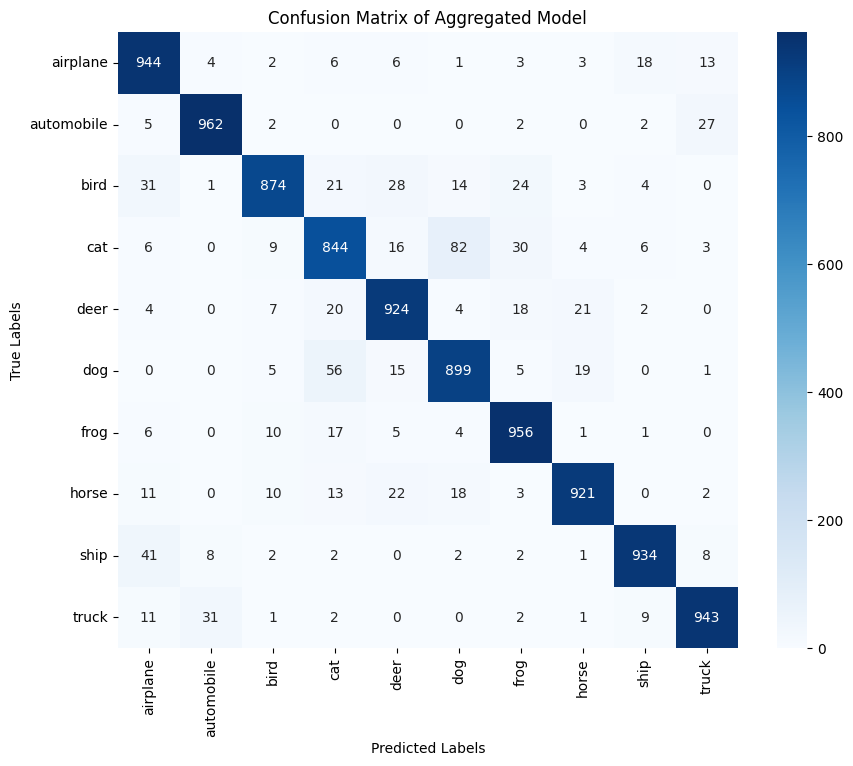

In [34]:
evaluate_aggregated_model(results, classes)